In [1]:
%load_ext autoreload
%autoreload 2

import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

from matplotlib.gridspec import GridSpec
from esda.moran import Moran
from cartopy import crs as ccrs

from math import ceil
import random
import textwrap

from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap
from pysal.lib import weights

import matplotlib.font_manager as fm

import src.cluster_anlaysis as ca
import src.compile_fns as cf

warnings.filterwarnings("ignore")

# Configure Seaborn styles
sns.set_style("whitegrid", {'grid.linestyle': 'dotted'})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

# Define default color palettes
colors_list = [
    "#FF0000", "#FF4500", "#FFA500", "#FFD700", "#FFFF00",
    "#ADFF2F", "#32CD32", "#008000"
]
default_cmap = mcolors.LinearSegmentedColormap.from_list("bright_RdGnYl", colors_list)
colors = sns.color_palette("RdYlGn", 5)

# Set custom font
def set_custom_font(font_path):
    try:
        fm.fontManager.addfont(font_path)
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Lato']
    except FileNotFoundError:
        print(f"Font file not found at: {font_path}. Using default font.")

font_path = 'data/utils/fonts/Lato-Regular.ttf'
set_custom_font(font_path)

In [2]:
india_boundary = gpd.read_file('data/admin_boundaries/district_boundaries_shp/output.shp')
india_intl = gpd.read_file('data/admin_boundaries/india_intl/india_intl.shp')

from shapely.ops import unary_union
def create_efficient_boundary(gdf):
    dissolved = gdf.dissolve()
    boundary = unary_union(dissolved.geometry)
    boundary_gdf = gpd.GeoDataFrame(geometry=[boundary], crs=gdf.crs)
    return boundary_gdf

boundary = create_efficient_boundary(india_boundary)
boundary_diff = gpd.overlay(boundary, india_intl, how='difference')

<Axes: >

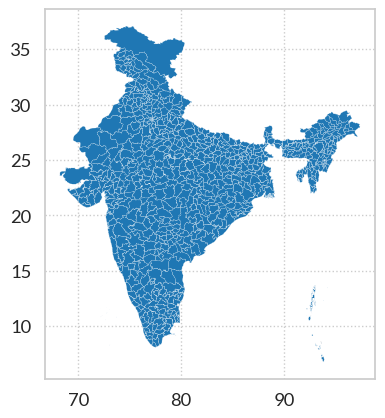

In [3]:
data_gdf = gpd.read_parquet("data/resilience_data.parquet")
ci_gdf = gpd.read_parquet("data/composite_resilience_indices.parquet")
coastal_cyclone_gdf = gpd.read_parquet("data/coastal_cyclone_data.parquet")
data_gdf.plot(edgecolor='white', linewidth=0.1)

In [4]:
# Assuming cf is imported elsewhere
indicators_dict = cf.indicators_dict
indicators_key_dict = cf.indicators_key_dict
indicator_vars = []
indicator_names = []
hazard_vars = []
var_breaks = [0]

for pillar in indicators_dict.keys():
    if pillar != 'hazard':
        var_breaks.append(var_breaks[-1] + len(indicators_dict[pillar].keys()))
        for key, field in indicators_dict[pillar].items():
            indicator_vars.append(field[0])
            indicator_names.append(key)
    else:
        for key, field in indicators_dict[pillar].items():
            hazard_vars.append(field[0])


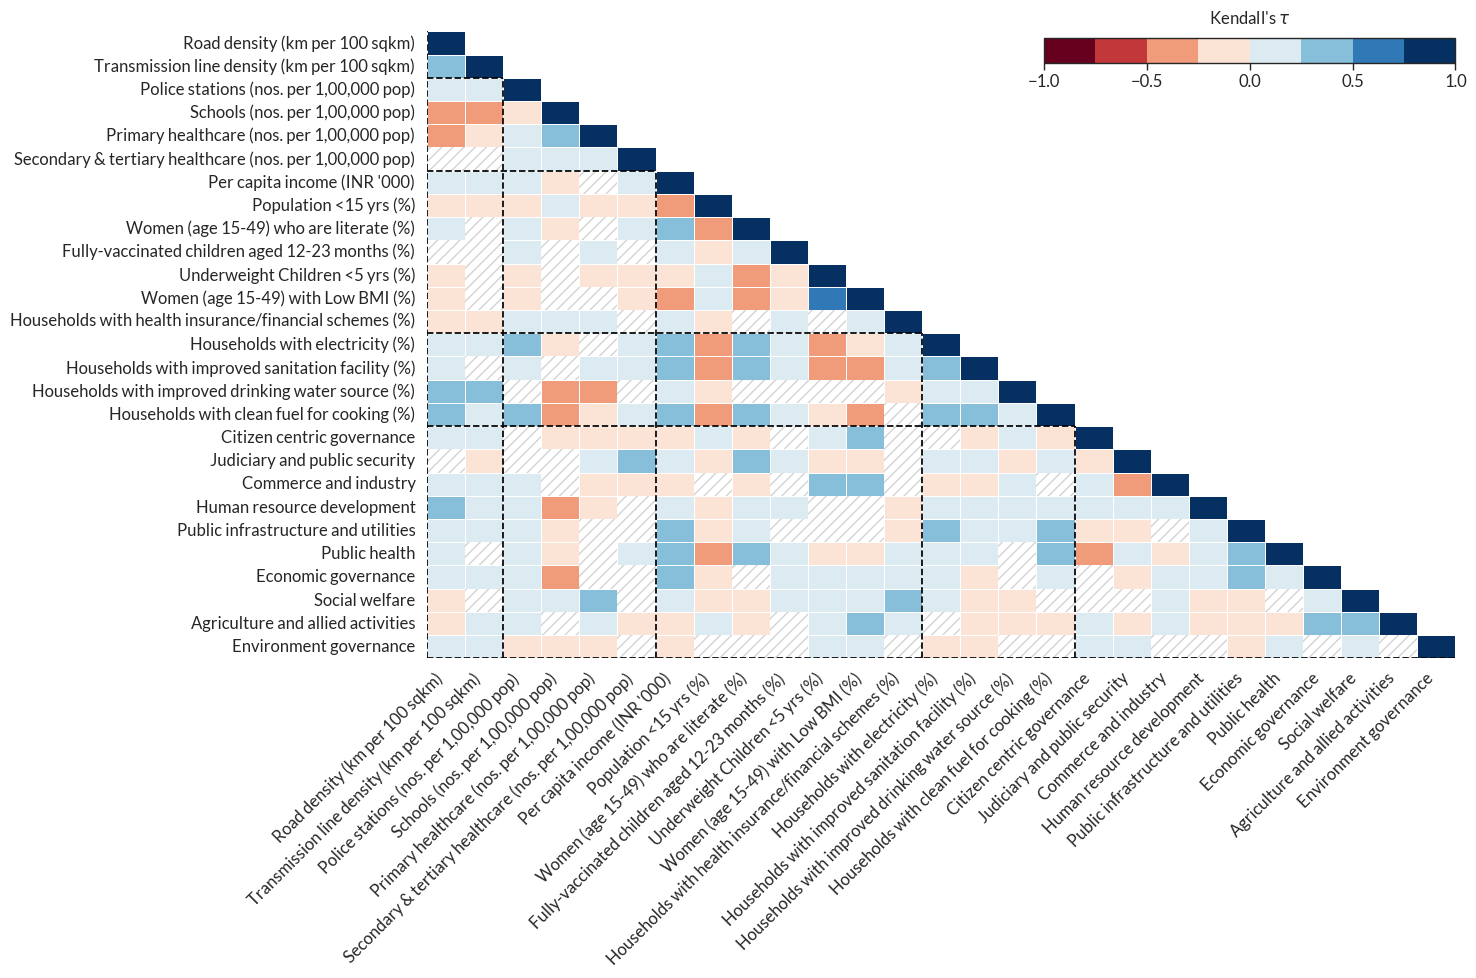

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.stats import kendalltau
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize matrices for Kendall's tau and p-values
n = len(indicator_vars)
tau_matrix = np.zeros((n, n))
pval_matrix = np.zeros((n, n))

# Compute Kendall's tau and p-values
for i in range(n):
    for j in range(n):
        if i != j:
            tau, p = kendalltau(data_gdf[indicator_vars[i]], data_gdf[indicator_vars[j]])
            tau_matrix[i, j] = tau
            pval_matrix[i, j] = p
        else:
            tau_matrix[i, j] = 1  # Diagonal
            pval_matrix[i, j] = np.nan  # Not applicable

# Create a mask for the upper triangle only
mask = np.triu(np.ones_like(tau_matrix, dtype=bool), k=1)

# Create a custom matrix for the background color, only showing significant values
color_matrix = tau_matrix.copy()
color_matrix[pval_matrix > 0.05] = np.nan  # Remove background color for non-significant values

# Plot the heatmap
sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lato']

f, ax = plt.subplots(figsize=(15, 10))
cmap = cm.get_cmap("RdBu", 8)

# Plot the heatmap with colors only for significant values
im = sns.heatmap(
    color_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
    square=False, linewidths=.5, vmin=-1,
    fmt='.2f', annot_kws={"size": 12},
    cbar=False  # Disable the default colorbar
)

# Overlay hatch patterns for non-significant values (p > 0.05)
for i in range(n):
    for j in range(n):
        if not mask[i, j] and pval_matrix[i, j] > 0.05:  # If not masked and p > 0.05
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='///', edgecolor='lightgray', lw=0))

# Set axis labels and formatting
ax.set_xticklabels(indicator_names, rotation=45, ha='right', size=12)
ax.set_yticklabels(indicator_names, rotation=0, va='center', size=12)


for i in var_breaks:
    ax.axvline(i, ymin = 0, ymax=1 - i/var_breaks[-1], color='black', linestyle='--', linewidth=1.25)

# Draw horizontal lines
for i in var_breaks:
    ax.axhline(i, xmin = 0, xmax =  i/var_breaks[-1], color='black', linestyle='--', linewidth=1.25)


divider = make_axes_locatable(ax)
cax = ax.inset_axes([0.6, 0.95, 0.4, 0.04])
cbar = plt.colorbar(im.get_children()[0], cax=cax, orientation="horizontal", ticks=[-1, -0.5, 0, 0.5, 1], fraction=0.05)
cbar.set_label("Kendall's $\\tau$ ", fontsize=12, labelpad=10)
#set label position to top
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()

# plt.savefig("graphics/indicators_corr.pdf", dpi=300, bbox_inches='tight')
plt.savefig("graphics/indicators_corr.png", dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# RUN THIS CELL TO LOAD THE DATA
FONT_FAMILY = 'sans-serif'
FONT_NAME = 'Lato'
PLOT_FONT_SIZE = 13
ANNOTATION_FONT_SIZE = 11
TITLE_WIDTH = 30
COLORBAR_FRAME_LINEWIDTH = 0.2
COLORBAR_FRAME_COLOR = 'lightgrey'
DEFAULT_CMAP = default_cmap

# Configure Fonts and Styles
plt.rcParams['font.family'] = FONT_FAMILY
plt.rcParams['font.sans-serif'] = [FONT_NAME]

# Utility Functions
def calculate_statistics(column_values, weight_matrix):
    """Calculate Moran's I and related statistics."""
    feature_mean = column_values.mean()
    feature_std = column_values.std()
    moran = Moran(column_values, weight_matrix)
    return feature_mean, feature_std, moran.I, moran.p_norm


def add_annotations(ax, feature_mean, feature_std, moran_i, moran_p):
    """Add statistical annotations to the plot."""
    annotation = (
        f"$\\mu$ = {feature_mean:.2f}\n"
        f"$\\sigma$ = {feature_std:.2f}\n"
        f"I = {moran_i:.2f}" + ("*" if moran_p < 0.05 else "")
    )
    ax.text(
        0.9, 0.15, annotation,
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=ANNOTATION_FONT_SIZE,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )


def plot_field(data_gdf, data_gdf_moran, field, field_info, dax, weight_matrix):
    """Plot individual fields with associated annotations."""
    column = field_info[0]
    cmap = DEFAULT_CMAP if field_info[3] == 'R' else DEFAULT_CMAP.reversed()

    # Plot the map
    im = data_gdf.plot(
        column=column, cmap=cmap, ax=dax,
        edgecolor=None, legend=True, alpha=1,
        legend_kwds={
            'orientation': "horizontal", 'location': "bottom",
            'shrink': 0.9, 'aspect': 17, 'pad': 0
        },
        missing_kwds={'color': 'whitesmoke', 'edgecolor': 'grey', 'alpha': 0.3},
        linewidth=0.05
    )

    # Configure colorbar
    colorbar = im.get_figure().get_axes()[-1]
    colorbar.tick_params(labelsize=ANNOTATION_FONT_SIZE)
    [spine.set_linewidth(COLORBAR_FRAME_LINEWIDTH) for spine in colorbar.spines.values()]
    [spine.set_edgecolor(COLORBAR_FRAME_COLOR) for spine in colorbar.spines.values()]

    # Gridlines
    dax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(),
                  linestyle='dotted', color='black', linewidth=0.5, alpha=0.1)

    # Calculate and annotate statistics
    column_values = data_gdf_moran[column]
    feature_mean, feature_std, moran_i, moran_p = calculate_statistics(column_values, weight_matrix)
    add_annotations(dax, feature_mean, feature_std, moran_i, moran_p)

    return im

prefix_dict = {
    'hazard': 'a', 'community': 'c', 'infrastructure_accessibility': 'd',
    'social_infrastructure': 'b', 'critical_infrastructure': 'a', 'state_capacity': 'e'
}

# Main Plotting Code
def main_plot(data_gdf, data_gdf_moran, weight_matrix, list_to_plot, plot_num):
    
    total_rows = sum(ceil(len(ca.indicators_dict[pillar].keys()) / max_cols) for pillar in list_to_plot)
    fig = plt.figure(figsize=(2.6 * max_cols, 3.6 * total_rows))
    gridspec = GridSpec(total_rows, max_cols, figure=fig)

    current_row = 0

    for indicator_index, key in enumerate(list_to_plot):
        field_dict = ca.indicators_dict[key]
        nrows = ceil(len(field_dict) / max_cols)

        # Add vertical category label
        prefix = prefix_dict[key]
        category_text = f"{prefix}. {key.replace('_', ' ').title()}"
        fig.text(
            -0.012, 1 - ((current_row + 1 / 2) / total_rows), category_text,
            ha="left", va="center", fontsize=14, rotation=90
        )

        # Plot each field
        for index, (feature, field_info) in enumerate(field_dict.items()):
            row, col = current_row + (index // max_cols), index % max_cols
            dax = fig.add_subplot(gridspec[row, col], projection=ccrs.PlateCarree())

            # Plot and configure the field
            plot_field(data_gdf, data_gdf_moran, feature, field_info, dax, weight_matrix)

            # Set title
            title = f"({roman_numerals[index]}) {feature}"
            dax.set_title("\n".join(textwrap.wrap(title, width=TITLE_WIDTH)), fontsize=PLOT_FONT_SIZE)
            dax.axis('off')

            # Add boundary layers
            outer_boundary.plot(ax=dax, color='black', linewidth=0.1)
            boundary_diff.plot(ax=dax, color='white', linewidth=0.1, edgecolor='black',
                               linestyle='--', alpha=0.8)

        current_row += nrows

    # Turn off unused gridspec positions
    for idx in range(total_rows * max_cols):
        if idx >= len(list_to_plot):
            fig.add_subplot(gridspec[idx // max_cols, idx % max_cols]).axis('off')

    plt.tight_layout()
    plt.show()

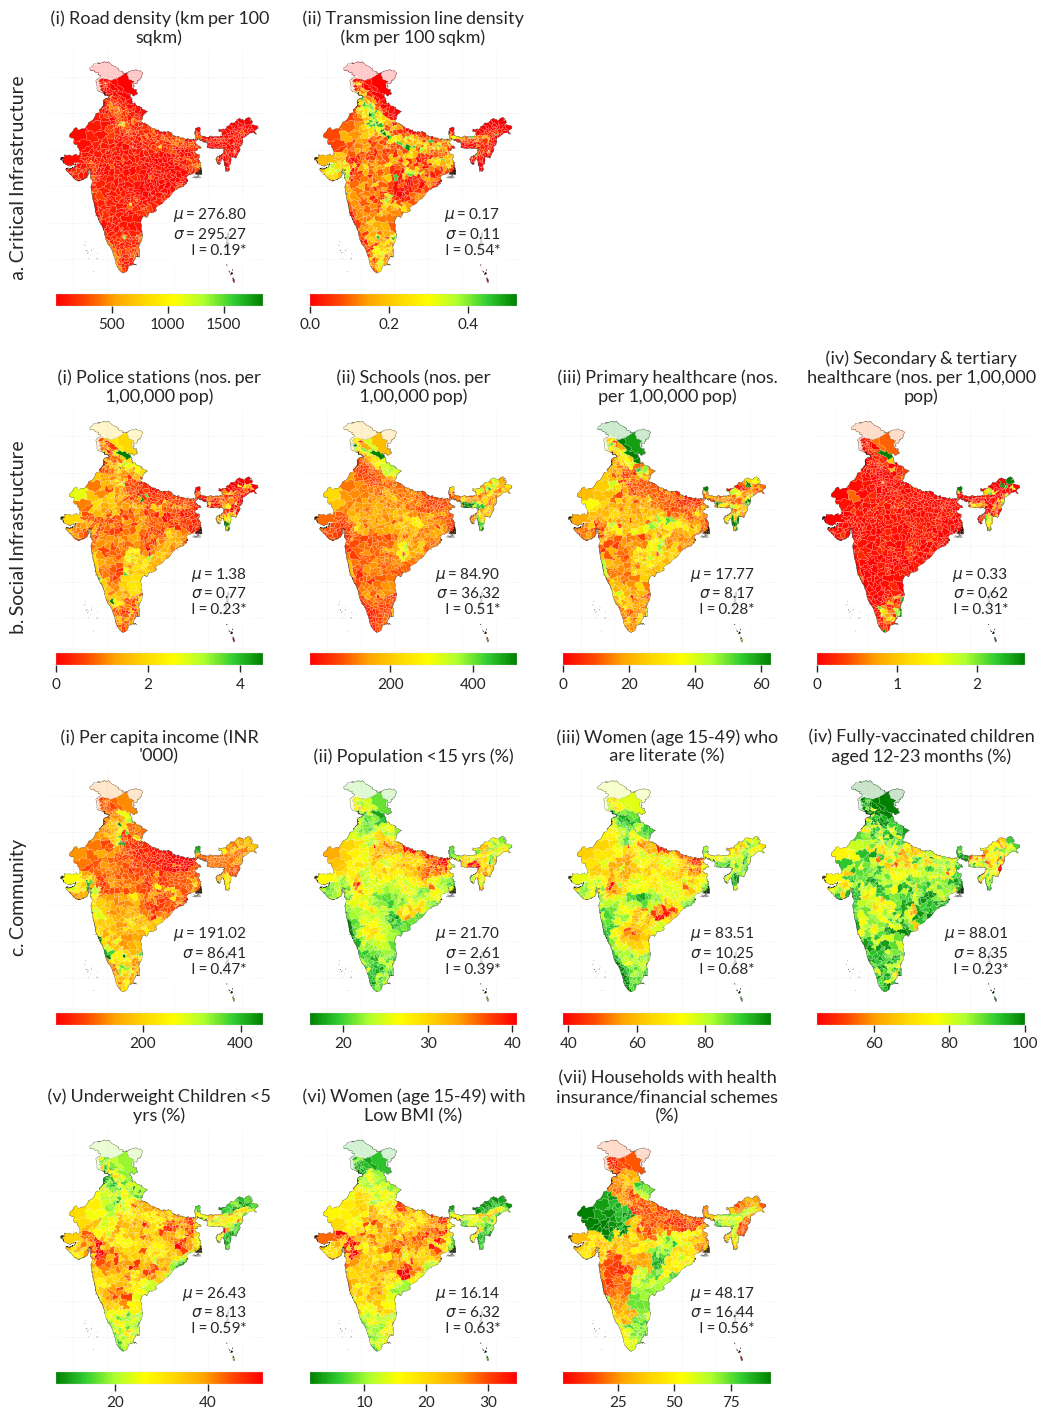

In [7]:

outer_boundary = boundary.boundary
data_gdf = data_gdf.to_crs(epsg=outer_boundary.crs.to_epsg())

# Call the Main Plot Function
list_to_plot, plot_num = ['critical_infrastructure', 'social_infrastructure', 'community',], 1
# list_to_plot, plot_num = ['infrastructure_accessibility','state_capacity'], 2
# list_to_plot, plot_num = ['hazard'], 3
max_cols = 4

indicator_vars = [values[0] for pillar in ca.indicators_dict.keys() for values in ca.indicators_dict[pillar].values()]

disconnected_ids = [0, 1, 2, 316]
data_gdf_moran = data_gdf[~data_gdf.index.isin(disconnected_ids)].dropna(subset=indicator_vars)
w = weights.Queen.from_dataframe(data_gdf_moran[indicator_vars + ['geometry']], use_index=False)

# Define Roman Numerals for Prefix
roman_numerals = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']

main_plot(data_gdf, data_gdf_moran, w, list_to_plot, plot_num)


## Composite Resilience Indicators

In [8]:


indicators_dict = ca.indicators_dict

data_resilience_gdf = data_gdf.copy()
for cluster_type in indicators_dict.keys():
    print("**************************************")
    for key, values in indicators_dict[cluster_type].items():
        print(key, values)
        
        if values[3] == 'V':
            data_resilience_gdf[values[0]] = -data_resilience_gdf[values[0]]

**************************************
Severe cyclones ['severe_cyclones', 0, -1, 'H']
Wind speed (knots) ['wind_speed_knots', 0, -1, 'H']
Maximum storm surge (m) ['pmss_m', 0, -1, 'H']
Maximum precipitation (cm) ['pmp_cm', 0, -1, 'H']
**************************************
Road density (km per 100 sqkm) ['roads_100sqkm', 0, -1, 'R']
Transmission line density (km per 100 sqkm) ['transmission_100sqkm', 0, -1, 'R']
**************************************
Police stations (nos. per 1,00,000 pop) ['police_density', 0, -1, 'R']
Schools (nos. per 1,00,000 pop) ['schools_density', 0, -1, 'R']
Primary healthcare (nos. per 1,00,000 pop) ['pri_health_density', 0, -1, 'R']
Secondary & tertiary healthcare (nos. per 1,00,000 pop) ['sec_health_density', 0, -1, 'R']
**************************************
Per capita income (INR '000) ['per_capita_income', 0, -1, 'R']
Population <15 yrs (%) ['perc_minors', 0, 100, 'V']
Women (age 15-49) who are literate (%) ['perc_women_literate', 0, 100, 'R']
Fully-vacc

In [9]:
for cluster_type in indicators_dict.keys():
    data_resilience_gdf[f'CI_{cluster_type}'] = ca.process_cluster(
        data_resilience_gdf, cluster_type
    )

C:\Users\srijithbalakrishnan\AppData\Local\Temp\ipykernel_24028\12328622.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


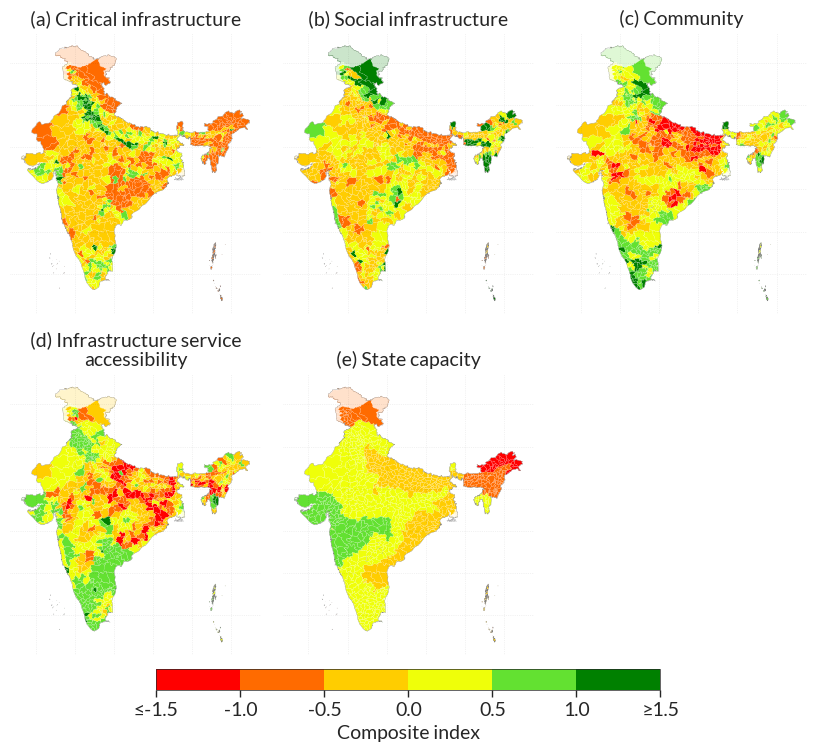

In [10]:
import numpy as np
import math
import textwrap
from pypalettes import load_cmap
import cartopy.crs as ccrs

cmap = load_cmap("Huida")

lower_bound = -1.5
upper_bound = 1.5
interval = 0.5

indicators_dict = ca.indicators_dict
cluster_types = [cluster_type for cluster_type in indicators_dict.keys() if cluster_type != 'hazard']

def create_custom_cmap(cmap_name='rainbow'):
    bounds = np.arange(lower_bound, upper_bound + interval, interval).tolist()
    cmap = default_cmap
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    return cmap, norm

total_figs = len(list(indicators_dict.keys())[1:])
ncols = 3
nrows = math.ceil(total_figs / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(2.8*ncols, 3.5*nrows), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lato']

indicators_key_dict = ca.indicators_key_dict

cmap_r, norm = create_custom_cmap('RdYlGn_r')  # You can change 'turbo_r' to any other colormap

for index, cluster_type in enumerate(cluster_types):
    prefix = chr(ord('`')+index+1)
    dax = axes[index]
    
    # Filter out NaN and Inf values
    column_name = f"CI_{cluster_type}"
    valid_data = data_resilience_gdf[np.isfinite(data_resilience_gdf[column_name])]
    
    valid_data.plot(column=column_name, cmap=cmap_r, 
                    norm=norm, 
                    ax=dax, edgecolor=None,
                    legend=False,
                    legend_kwds={'orientation': "horizontal", "location": "bottom", "shrink": 0.65, 
                                 "label": "Composite index"},
                    missing_kwds={'color': 'gainsboro'}, linewidth=0.05)
    boundary.boundary.plot(ax=dax, color='grey', linewidth=0.2)
    boundary_diff.plot(ax=dax, color='white', linewidth=0.1, alpha = 0.8)
    
    # dax.set_title(f"({prefix}) {cluster_type}")
    title = f"({prefix}) {indicators_key_dict[cluster_type]}"
    wrapped_title = "\n".join(textwrap.wrap(title, width=30))
    dax.set_title(wrapped_title, fontsize=14)
    dax.axis('off')

    gridlines = dax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='dotted', color='black', linewidth=0.5, alpha=0.1)

# Switch off the axis for the remaining plots
for i in range(total_figs, len(axes)):
    axes[i].axis('off')

# Create a new axis for the colorbar
cbar_ax = fig.add_axes([0.2, -0.0, 0.6, 0.03])  # [left, bot tom, width, height]
# cbar_ax = fig.add_axes([0.3, -0.0, 0.4, 0.06])  # [left, bot tom, width, height]

# Create a custom colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.outline.set_linewidth(0.5)
cbar.set_ticks(np.arange(lower_bound, upper_bound + interval, interval).tolist())
cbar.set_ticklabels(['≤' + str(lower_bound)] + [str(i) for i in np.arange(lower_bound + interval, upper_bound, interval).tolist()] + ['≥' + str(upper_bound)])
cbar.set_label("Composite index", fontsize=14)

cbar.ax.tick_params(labelsize=14)

# Save the plot
plt.tight_layout()
# plt.savefig(f"maps/CompositeIndex_all_districts.png", dpi=300, bbox_inches='tight')
# plt.savefig(f"maps/cluster_score_cyclone_districts.pdf", dpi=300, bbox_inches='tight')
plt.show()


## Case Study: Cyclone-prone District Clustering

In [11]:
import src.pca_clustering as pc
# Perform clustering
random_state =  22 #random.randint(0, 100) #27
print(f"Random state: {random_state}")

sns.set_style("whitegrid", {'grid.linestyle': 'dotted'})
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.5})

clustering_method = 'hierachical'
cluster_types = [cluster_type for cluster_type in indicators_dict.keys() if cluster_type != 'hazard']
cluster_df = coastal_cyclone_gdf[[f'CI_{cluster_type}' for cluster_type in cluster_types]].copy()
labels, centroids, num_clusters = pc.perform_clustering(clustering_method, cluster_df, random_state, num_clusters=7)

coastal_cyclone_gdf['cluster'] = labels
for cluster_type in cluster_types:
    coastal_cyclone_gdf[f'CI_{cluster_type}_centroid'] = coastal_cyclone_gdf['cluster'].map(centroids[f'CI_{cluster_type}'].to_dict()).values


ModuleNotFoundError: No module named 'kneed'

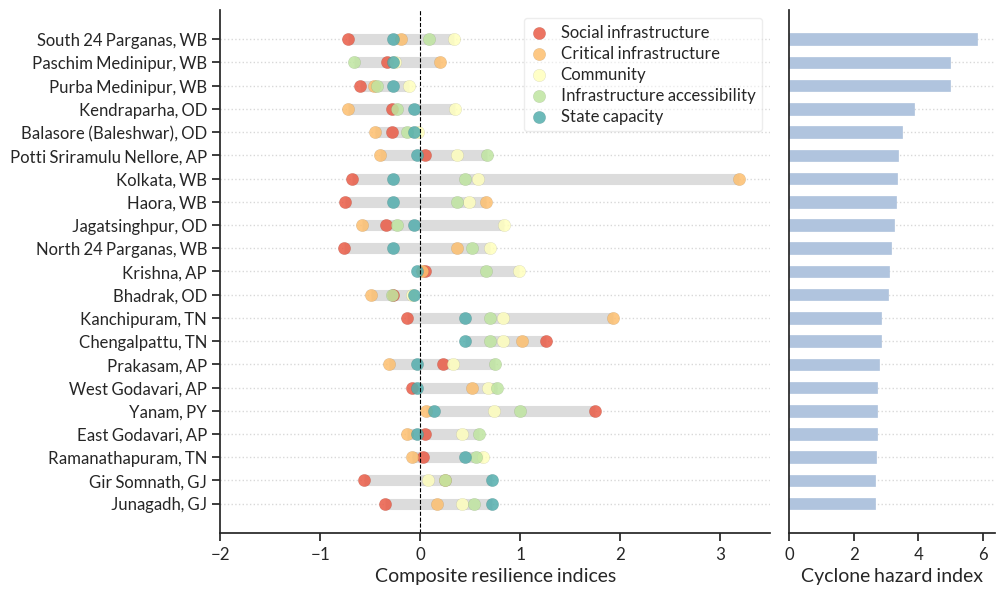

In [ ]:
# Plot the composite resilience scores of districts with highest cyclone hazard exposure

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

num_dists = 20
plot_gdf_sorted = coastal_cyclone_gdf.sort_values(['CI_hazard'], ascending=False).iloc[0:num_dists+ 1]

states_to_consider = {'West Bengal': 'WB', 'Odisha': 'OD', 'Tamil Nadu': 
                      'TN', 'Gujarat': 'GJ', 'Andhra Pradesh': 'AP', 
                      'Karnataka': 'KA', 'Maharashtra': 'MH', 'Kerala': 'KL', 
                      'Goa': 'GA', 'Lakshadweep': 'LD', 'Puducherry': 'PY', 'Andaman & Nicobar Islands': 'A&N',
                      'Dadra & Nagar Haveli': 'D&H', 'Daman & Diu': 'D&D'}

spider_gdf = plot_gdf_sorted[plot_gdf_sorted['state'].isin(states_to_consider.keys())]
spider_gdf['dist_state'] = [f"{x['district']}, {states_to_consider[x['state']]}" for _, x in spider_gdf.iterrows()]
spider_gdf['dist_state'] = spider_gdf['dist_state'].str.replace('Twenty-Four', '24')

spider_gdf['average_score'] = spider_gdf[[f"CI_{cluster_type}" for cluster_type in cluster_types]].mean(axis=1)
spider_gdf_sorted = spider_gdf.iloc[::-1].reset_index(drop=True)

fig = plt.figure(figsize=(10, num_dists*0.34))
sns.set_style("ticks", {'grid.linestyle': 'solid'})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lato']

from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 2, width_ratios=[2, 0.75], wspace=0.05)

ax1 = fig.add_subplot(gs[0])
district_spacing = 0.1  
num_districts = len(spider_gdf_sorted)

y_positions = np.arange(num_districts) * district_spacing
categories = ["CI_social_infrastructure", "CI_critical_infrastructure","CI_community","CI_infrastructure_accessibility","CI_state_capacity"]
labels = ["Social infrastructure","Critical infrastructure","Community","Infrastructure accessibility","State capacity"]

category_colors = sns.color_palette("Spectral", len(categories))
for i, district in enumerate(spider_gdf_sorted['dist_state']):
    # Extract data for the current district
    data = spider_gdf_sorted.loc[i, categories]
    min_value = data.min()
    max_value = data.max()
    mean_value = data.mean()
    ax1.hlines(
        y=y_positions[i], xmin=min_value, xmax=max_value, 
        color='gainsboro', alpha=1, linewidth=8, zorder=1
    )
    
    for category, label, color in zip(categories, labels, category_colors):
        value = spider_gdf_sorted.loc[i, category]
        ax1.scatter(
            value, y_positions[i], color=color, s=80, zorder=2,
            label=label if i == 0 else "", alpha=0.85, 
            edgecolor='black', linewidth=0.05
        )

ax1.set_yticks(y_positions)
ax1.set_yticklabels(spider_gdf_sorted['dist_state'], fontsize=12)
ax1.set_xlabel('Composite resilience indices', fontsize=14)
ax1.set_xlim(-2, 3.5)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax1.grid(axis='y', linestyle=':', alpha=0.3, color='grey')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.legend(
    loc='upper right', bbox_to_anchor=(1, 1), fontsize=12, 
    handlelength=1.0, labelspacing=0.3, ncol=1,
    # title="Categories", title_fontsize=13,
    framealpha=0.5, facecolor='white', edgecolor='gainsboro', frameon=True
)

ax2 = fig.add_subplot(gs[1], sharey=ax1)
hazard_values = spider_gdf_sorted['CI_hazard']
ax2.barh(
    y_positions, hazard_values, height=district_spacing * 0.5, color='lightsteelblue', alpha=1, 
    edgecolor='lightsteelblue', linewidth=0.5
)
ax2.set_yticks(y_positions)  
ax2.set_xlabel('Cyclone hazard index', fontsize=14)
ax2.set_xlim(min(0, hazard_values.min()*1.1), hazard_values.max() * 1.1)  # Adjust x-axis limits
ax2.tick_params(axis='x', labelsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='y', linestyle=':', alpha=0.3, color='grey')
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)

fig.tight_layout()
# plt.savefig("maps/main_districts_with_hazard_subplot.png", dpi=600, bbox_inches='tight')
plt.savefig("../maps/main_districts_with_hazard_subplot.pdf", dpi=300, bbox_inches='tight')
plt.show()


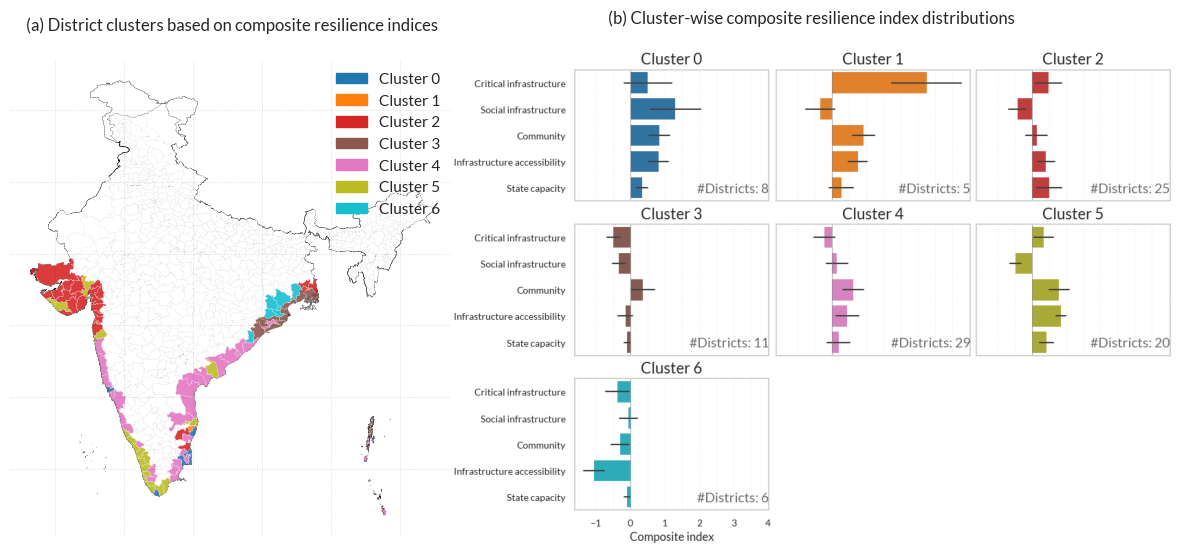

In [ ]:
# Plot the clusters of hazard prone districts with similar resilience patterns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator
from cartopy import crs as ccrs

# Global Plot Style Configuration
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lato']
plt.rcParams.update({'font.size': 10})


def create_custom_cmap(num_clusters):
    """Create a custom colormap for cluster visualization."""
    colors = plt.get_cmap('tab10')(np.linspace(0, 1, num_clusters))
    return LinearSegmentedColormap.from_list("custom_lemon", colors, N=num_clusters)


def add_cluster_legend(ax, cmap, unique_clusters):
    """Add a legend for cluster values to a given axis."""
    legend_handles = [
        mpatches.Patch(color=cmap(idx / (len(unique_clusters) - 1)), label=f'Cluster {idx}')
        for idx in unique_clusters
    ]
    legend = ax.legend(
        handles=legend_handles, loc='best', fontsize=11, title_fontsize=13, ncol=1,
        framealpha=0.1, frameon=True, edgecolor='lightgrey'
    )
    legend.get_frame().set_linewidth(0.2)


def configure_map(ax, data_gdf, boundary, boundary_diff, coastal_cyclone_gdf, cmap):
    """Configure the map plot with boundaries and clusters."""
    ax.set_title('(a) District clusters based on composite resilience indices', fontsize=12, pad=20)
    
    # Plot layers
    data_gdf.plot(ax=ax, color='white', linewidth=0.1, edgecolor='lightgrey', alpha=0.8)
    boundary.boundary.plot(ax=ax, color='black', linewidth=0.1, alpha=1)
    boundary_diff.plot(ax=ax, color='white', edgecolor='black', linewidth=0.2, linestyle='--')
    coastal_cyclone_gdf.plot(
        ax=ax, column='cluster', cmap=cmap, edgecolor=None, legend=False,
        missing_kwds={'color': 'lightgrey'}, linewidth=0.1, alpha=0.9
    )

    # Configure appearance
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='dotted', color='black', linewidth=0.5, alpha=0.2)


def plot_cluster_distributions(data_melted, unique_clusters, cmap, num_clusters):
    """Create subplots showing cluster-wise composite index distributions."""
    ncols = 3
    num_rows = -(-len(unique_clusters) // ncols)  # Ceiling division
    fig, axes = plt.subplots(
        num_rows, ncols, figsize=(3.5 * ncols, 2.4 * num_rows),
        constrained_layout=True, sharex=True, sharey=True
    )
    axes = axes.flatten()

    for idx, cluster in enumerate(unique_clusters):
        cluster_data = data_melted[data_melted["cluster"] == cluster]
        sns.barplot(
            data=cluster_data, x="Value", y="CI_Variable", errorbar="sd",
            palette=[cmap(idx / (num_clusters - 1))], orient="h",
            alpha=1, linewidth=0.1, edgecolor='gainsboro', errwidth=1.5, ax=axes[idx]
        )

        # Add annotations
        district_count = coastal_cyclone_gdf[coastal_cyclone_gdf['cluster'] == cluster].shape[0]
        axes[idx].annotate(
            f"#Districts: {district_count}", xy=(1, 0.175), xytext=(0, -5),
            xycoords='axes fraction', textcoords='offset points',
            ha='right', va='top', fontsize=14, color='dimgrey'
        )

        # Customize the plot
        axes[idx].set_title(f"Cluster {cluster}", fontsize=16)
        axes[idx].set_xlabel("Composite index", fontsize=12)
        axes[idx].set_ylabel("")
        axes[idx].axvline(0, color='grey', linewidth=0.5)
        axes[idx].tick_params(axis='both', which='major', labelsize=10)
        axes[idx].xaxis.set_minor_locator(AutoMinorLocator(2))
        axes[idx].grid(axis='x', which='both', linestyle=':', linewidth=0.5, alpha=0.7)

    # Remove extra axes
    for idx in range(len(unique_clusters), len(axes)):
        fig.delaxes(axes[idx])

    return fig


def main_plot(data_gdf, boundary, boundary_diff, coastal_cyclone_gdf, num_clusters):
    """Main function to create the combined cluster map and subplots."""
    fig = plt.figure(figsize=(15, 6.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.23, 2], figure=fig, wspace=-0.005)

    # Custom colormap
    cmap = create_custom_cmap(num_clusters)
    unique_clusters = sorted(coastal_cyclone_gdf["cluster"].unique())

    # Map Plot (Left Panel)
    ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    configure_map(ax_map, data_gdf, boundary, boundary_diff, coastal_cyclone_gdf, cmap)
    add_cluster_legend(ax_map, cmap, unique_clusters)

    # Prepare data for cluster distribution plots
    ci_columns = [
        "CI_critical_infrastructure", "CI_social_infrastructure", "CI_community",
        "CI_infrastructure_accessibility", "CI_state_capacity"
    ]
    ci_column_titles = [
        "Critical infrastructure", "Social infrastructure", "Community",
        "Infrastructure accessibility", "State capacity"
    ]
    ci_label_mapping = dict(zip(ci_columns, ci_column_titles))

    # Melt data for Seaborn
    data_melted = coastal_cyclone_gdf.melt(
        id_vars=["cluster"], value_vars=ci_columns,
        var_name="CI_Variable", value_name="Value"
    )
    data_melted["CI_Variable"] = data_melted["CI_Variable"].map(ci_label_mapping)
    data_melted["cluster"] = data_melted["cluster"].astype(int)

    # Cluster-wise Subplots
    inner_fig = plot_cluster_distributions(data_melted, unique_clusters, cmap, num_clusters)

    # Embed bar plots into the right panel
    ax_bars = fig.add_subplot(gs[1:])
    ax_bars.set_title('(b) Cluster-wise composite resilience index distributions', fontsize=12, pad=20)
    ax_bars.axis("off")
    inner_fig.canvas.draw()
    inner_image = np.array(inner_fig.canvas.renderer.buffer_rgba())
    ax_bars.imshow(inner_image)

    # Finalize and save the figure
    plt.close(inner_fig)
    plt.tight_layout()
    # plt.savefig("maps/optimized_combined_cluster_plots.png", dpi=600, bbox_inches='tight')
    plt.show()


# Call the main plot function with the required arguments
main_plot(data_gdf, boundary, boundary_diff, coastal_cyclone_gdf, num_clusters)


In [15]:
# data_resilience_gdf[['district','state','distid','geometry',
#     'CI_hazard','CI_critical_infrastructure','CI_social_infrastructure',
#     'CI_community','CI_infrastructure_accessibility','CI_state_capacity']].to_parquet("data/composite_resilience_indices.parquet")